## Загрузка датасета и изучение общей информации

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
data=pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.info() #количество строк в столбцах не совпадает, нужно заполнять пропуски или удалять строки

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [2]:
data.duplicated().sum(), data.isna().sum()
#дубликаторв нет, пропуски есть, необходимо детально изучить пропуски

(0,
 total_images                0
 last_price                  0
 total_area                  0
 first_day_exposition        0
 rooms                       0
 ceiling_height           9195
 floors_total               86
 living_area              1903
 floor                       0
 is_apartment            20924
 studio                      0
 open_plan                   0
 kitchen_area             2278
 balcony                 11519
 locality_name              49
 airports_nearest         5542
 cityCenters_nearest      5519
 parks_around3000         5518
 parks_nearest           15620
 ponds_around3000         5518
 ponds_nearest           14589
 days_exposition          3181
 dtype: int64)


## Предобработка данных

<div class="alert alert-block alert-info">
- Пропуски в days_exposition не заполняю, насколько понимаю если стоит пропуск то объявление активно, все остальное архив проданных объектов
<br>- Пропуски в столбцах ponds_nearest, parks_nearest, airports_nearest,cityCenters_nearest не заполняю, т.к. это скорее всего обусловленно отсутствием данных критерей
<br>- Пропуски в столбцах kitchen_area и living_area  не заполняю, т.к. не считаю его возможным заполнить средним или медианным значением без участия клиента


In [3]:
data['ponds_around3000']=data['ponds_around3000'].fillna(0).astype(int) #заполняю пропуски, меняю формат данных
data['parks_around3000']=data['parks_around3000'].fillna(0).astype(int) #заполняю пропуски, меняю формат данных
data['balcony']=data['balcony'].fillna(0).astype(int) #заполняю пропуски, меняю формат данных
data['locality_name']=data['locality_name'].str.replace('поселок', 'посёлок') #убираю задвоение из-за е-ё
data=data.dropna(subset=['locality_name']) #удаляю 49 строк где не указана локация, на мой взгляд это информация критичная

data['is_apartment']=data['is_apartment'].fillna(False)
data['floors_total']=data['floors_total'].fillna(data['floor']).astype(int) #заполняю пропуски, меняю формат данных. Предполагаю,floor = floors_total 

data['last_price']=data['last_price'].astype(int)
data.loc[(data['ceiling_height']>9), 'ceiling_height'] = data['ceiling_height']/10
data.loc[(data['ceiling_height']<2), 'ceiling_height'] = data['ceiling_height'].median() #аномально маленькие потолки до 2х метров меняю на значение медианы
data['ceiling_height']=data['ceiling_height'].fillna(data['ceiling_height'].median()) #заполняю пропуски

## Расчет и добавление новых столбцов в таблицу

In [4]:
def type_floor(index):
    if index['floor'] == 1:
        return 'первый'
    if index['floor'] == index['floors_total']:
        return 'последний'
    else:
        return 'другой'
    
data['total_area']=data['living_area']+data['kitchen_area'] #добавляю столбец общей площади
data['price_one_meter']=data['last_price']/data['total_area'] #2707 пустых значений, возможно стоит заполнить площади медианным значением?
data['cityCenters_nearest_km']=data['cityCenters_nearest']//1000 # перевожу метры в километры, формат оставляю десятичной дроби, из-за пропусков
data['type_floor']=data.apply(type_floor, axis=1)

data['day_exposition']=pd.to_datetime(data['first_day_exposition'], yearfirst=True).dt.weekday
data['month_exposition']=pd.to_datetime(data['first_day_exposition'], yearfirst=True).dt.month 
data['year_exposition']=pd.to_datetime(data['first_day_exposition'], yearfirst=True).dt.year 

print(data['cityCenters_nearest'].median())

13105.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   total_images            23650 non-null  int64  
 1   last_price              23650 non-null  int64  
 2   total_area              20943 non-null  float64
 3   first_day_exposition    23650 non-null  object 
 4   rooms                   23650 non-null  int64  
 5   ceiling_height          23650 non-null  float64
 6   floors_total            23650 non-null  int64  
 7   living_area             21752 non-null  float64
 8   floor                   23650 non-null  int64  
 9   is_apartment            23650 non-null  bool   
 10  studio                  23650 non-null  bool   
 11  open_plan               23650 non-null  bool   
 12  kitchen_area            21381 non-null  float64
 13  balcony                 23650 non-null  int64  
 14  locality_name           23650 non-null

## Проведение исследовательского анализа

In [6]:
data.pivot_table(index='type_floor', values='last_price', aggfunc='count')

,last_price
type_floor,
другой,17326
первый,2912
последний,3412


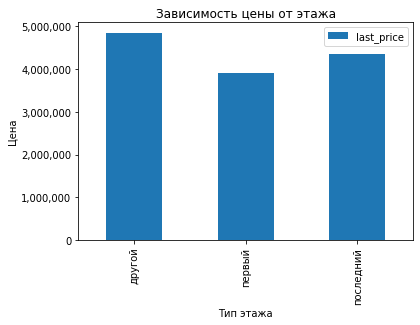

In [7]:
import matplotlib
ax = (data.pivot_table(index='type_floor', values='last_price', aggfunc='median').plot(kind='bar', style='o-', title='Зависимость цены от этажа')
)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set(xlabel='Тип этажа', ylabel='Цена');

array([[<AxesSubplot:title={'center':'floor'}>]], dtype=object)

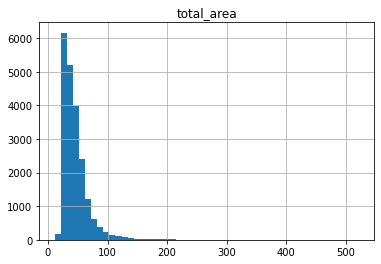

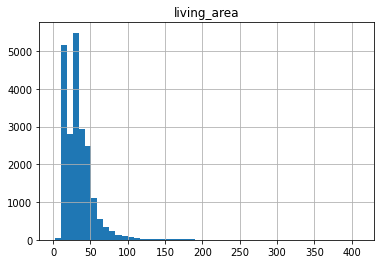

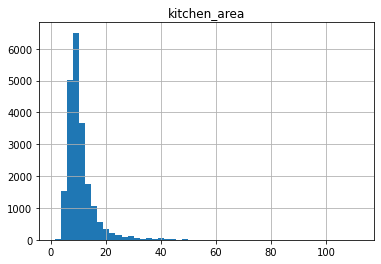

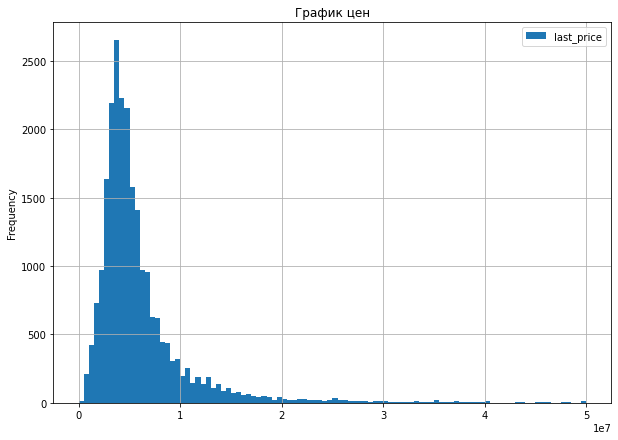

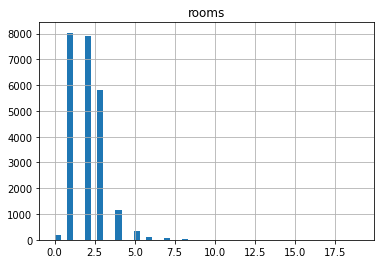

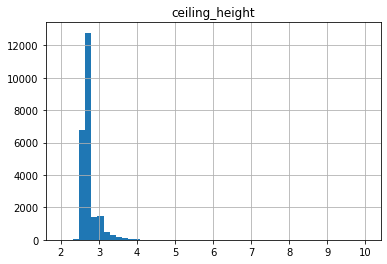

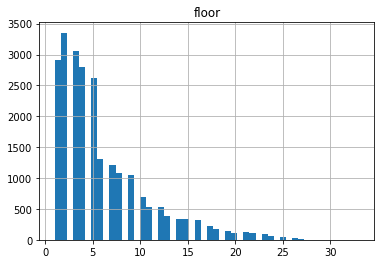

In [8]:
data.hist('total_area', bins=50) #распределение данных похоже на нормальное
data.hist('living_area', bins=50) #распределение данных похоже на нормальное
data.hist('kitchen_area', bins=50) #распределение данных похоже на нормальное
data.plot(y = 'last_price', kind = 'hist', bins = 100, grid=True, range = (0,50000000), figsize = (10,7), title='График цен') #
data.hist('rooms', bins=50) # 1 и 2 комнатные помещения самые распостраненные
data.hist('ceiling_height', bins=50) #все ок, средняя высота потолка соблюдается
data.hist('floor', bins=50) #нормальное распределение до 5го этажа включительно самые распространенные помещения

array([[<AxesSubplot:title={'center':'month_exposition'}>]], dtype=object)

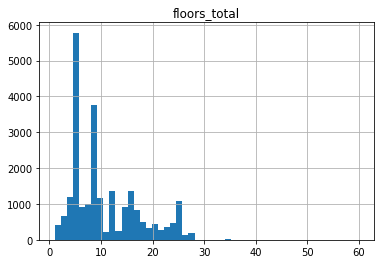

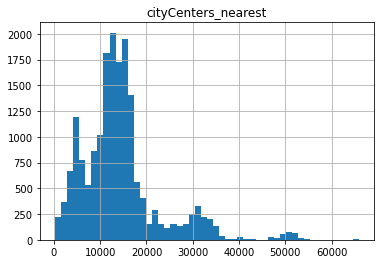

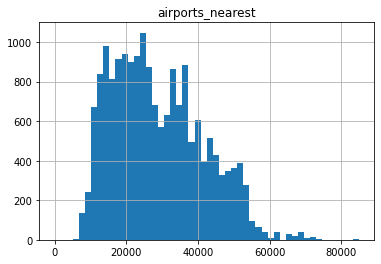

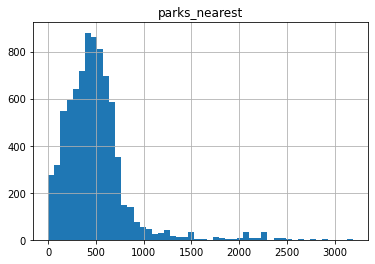

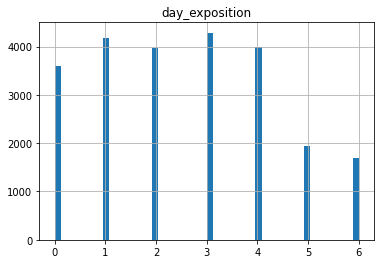

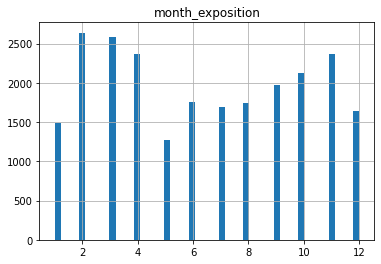

In [9]:
data.hist('floors_total', bins=50) #два пика, 4 и 7 этажные здания встречаются чаще всего
data.hist('cityCenters_nearest', bins=50) #нормальное распреледение, медианное значние отдаления 14км
data.hist('airports_nearest', bins=50) #от 15 до 50км до аэропорта, хорошая выборка данных
data.hist('parks_nearest', bins=50) #нормальное распределение данных, больше всего помещений в отдалении от парка на 500м.
data.hist('day_exposition', bins=50) #в сб и вск выставляют объявления меньше всего
data.hist('month_exposition', bins=50) #явно наблюдается сезонность

95.0
180.7531998045921


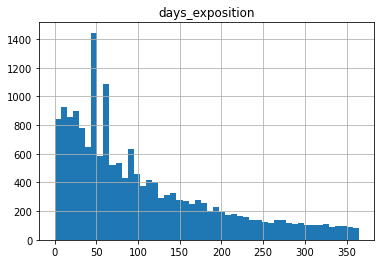

In [10]:
data.hist('days_exposition', bins=50, range=(0, 365)) #чаще всего квартиры продавались в районе50-60 дней
print(data['days_exposition'].median()) # медиана 95 дней
print(data['days_exposition'].mean()) #среднее 180 дней, возможно если отсечь неадекватно длинные сроки(больше года) ситуация выровняется


In [11]:
print('Коэфициент зависимости цены от общей площади', data['total_area'].corr(data['last_price'])) # от общей площади самая большая кореляция
print('Коэфициент зависимости цены от жилой площади', data['living_area'].corr(data['last_price']))
print('Коэфициент зависимости цены от площади кухни', data['kitchen_area'].corr(data['last_price']))
print('Коэфициент зависимости цены от кол-ва комнат', data['rooms'].corr(data['last_price']))
print('Коэфициент зависимости цены от дня размещения объявления ', data['day_exposition'].corr(data['last_price'])) #нет зависимости от времени размещения 
print('Коэфициент зависимости цены от месяца размещения объявления ', data['month_exposition'].corr(data['last_price'])) #нет зависимости от времени размещения 
print('Коэфициент зависимости цены от года размещения объявления ', data['year_exposition'].corr(data['last_price'])) #нет зависимости от времени размещения 
print()
t1=data.pivot_table(index='locality_name', values='price_one_meter', aggfunc='mean').sort_values(by='price_one_meter', ascending=False)
print(t1.head(10))
print()
print(t1.tail(10))
print()
print()
print(data.query('locality_name == "Санкт-Петербург"').pivot_table(index='locality_name', columns='cityCenters_nearest_km', values='last_price', aggfunc='mean'))

Коэфициент зависимости цены от общей площади 0.6502516395138324
Коэфициент зависимости цены от жилой площади 0.5665168840375522
Коэфициент зависимости цены от площади кухни 0.5202330465436197
Коэфициент зависимости цены от кол-ва комнат 0.36342062218770704
Коэфициент зависимости цены от дня размещения объявления  0.0016068614793023977
Коэфициент зависимости цены от месяца размещения объявления  0.00274102941992422
Коэфициент зависимости цены от года размещения объявления  -0.042927051076831486

                   price_one_meter
locality_name                     
посёлок Репино       162023.005924
Санкт-Петербург      154418.273396
Зеленогорск          151495.221688
Сестрорецк           140234.193696
Пушкин               140142.828649
Кудрово              135495.523325
посёлок Парголово    127666.023393
деревня Мистолово    127329.216009
деревня Кудрово      125382.124671
Мурино               123234.950665

                                    price_one_meter
locality_name              

In [12]:
data.corr()
#проверяю результат сводной таблицей по корреляции

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_meter,cityCenters_nearest_km,day_exposition,month_exposition,year_exposition
total_images,1.000000,0.104558,0.114264,0.099660,0.048304,0.010548,0.104952,0.030832,0.010512,-0.029389,...,0.036990,-0.008158,0.011077,-0.003424,-0.027415,0.126081,-0.047887,-0.010510,0.004837,0.140884
last_price,0.104558,1.000000,0.650252,0.363421,0.274653,-0.006762,0.566517,0.026770,0.026964,-0.025363,...,0.197704,-0.016310,0.208842,-0.085193,0.080937,0.727779,-0.206954,0.001607,0.002741,-0.042927
total_area,0.114264,0.650252,1.000000,0.809349,0.393730,-0.101428,0.977440,-0.047800,0.032141,NaN,...,0.209993,-0.034565,0.199721,-0.098699,0.144901,0.236408,-0.244559,-0.007945,0.000952,-0.075700
rooms,0.099660,0.363421,0.809349,1.000000,0.227129,-0.226896,0.846088,-0.150604,0.000422,-0.147371,...,0.157095,-0.054236,0.121450,-0.058705,0.126497,0.031222,-0.184543,-0.004316,-0.004388,-0.054641
ceiling_height,0.048304,0.274653,0.393730,0.227129,1.000000,-0.079897,0.356256,-0.043806,0.089118,0.010003,...,0.231422,-0.056890,0.204246,-0.107493,0.103045,0.267792,-0.276057,-0.021569,-0.001340,-0.050378
floors_total,0.010548,-0.006762,-0.101428,-0.226896,-0.079897,1.000000,-0.168827,0.678060,-0.026345,0.069591,...,-0.158492,0.097051,-0.049201,0.040189,-0.052773,0.172603,0.018466,0.012543,0.016016,0.008477
living_area,0.104952,0.566517,0.977440,0.846088,0.356256,-0.168827,1.000000,-0.096825,0.027007,-0.056235,...,0.212109,-0.050004,0.182950,-0.082420,0.142171,0.172585,-0.231429,-0.005597,-0.002602,-0.072166
floor,0.030832,0.026770,-0.047800,-0.150604,-0.043806,0.678060,-0.096825,1.000000,-0.013321,0.036978,...,-0.104945,0.073157,-0.029920,0.025923,-0.039501,0.147074,0.008531,0.011746,0.019480,0.005273
is_apartment,0.010512,0.026964,0.032141,0.000422,0.089118,-0.026345,0.027007,-0.013321,1.000000,-0.003665,...,0.021581,-0.033422,0.024467,0.003344,0.015303,0.035232,0.003270,-0.009488,0.002352,0.009313
studio,-0.029389,-0.025363,NaN,-0.147371,0.010003,0.069591,-0.056235,0.036978,-0.003665,1.000000,...,-0.032055,0.009132,-0.009656,0.002587,-0.022447,NaN,-0.006809,-0.000818,0.000944,0.011775


### Общий вывод

Исследуя ахив объявлений о продаже недвижимости по Санкт-Петербургу и ближайшим окрестностям можно сделать следующие выводы:
  - Средняя стоимость недвижимости растет по мере приближения к территориальному центру (Санкт-Петербургу);
  - Самый большой коэфициент влияющий на стоимость квартиры: Общая площадь. В меньшей мере на стоимость влияют (по отдельности): жилая площадь, площадь кухни, кол-во комнат. Дата размещения объявления и тип квартиры (этажность) на конечную стоимость влияния не оказывают;
  - Средняя стоимость квадратного метра нежвижимости в п.Репино выше, чем в Санкт-Петербурге